In [108]:
import sqlite3
import pandas as pd
import os
import matplotlib.pyplot as plt
import yfinance as yf

verbose = False

In [87]:
directory = r'C:\Users\mattl\Downloads\all_transactions.csv'

try:
    df = pd.read_csv(directory)
    print("File Loaded")
except Exception as e: 
     print(f"Error Occured while lodeing file {e}")


# Convert the 'transaction_date' column to datetime, handling errors
df['transaction_date'] = pd.to_datetime(df['transaction_date'], errors='coerce')

# Filter out rows where 'transaction_date' couldn't be converted (i.e., is NaT)
df = df[df['transaction_date'].notna()]

# # Extract the year from 'transaction_date'
df['transaction_year'] = df['transaction_date'].dt.year

df.head()

File Loaded


C:\Users\mattl\AppData\Local\Temp\ipykernel_9772\1912450232.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['transaction_date'] = pd.to_datetime(df['transaction_date'], errors='coerce')


,disclosure_year,disclosure_date,transaction_date,owner,ticker,asset_description,type,amount,representative,district,state,ptr_link,cap_gains_over_200_usd,industry,sector,party,transaction_year
12,2023,1/2/2023,2023-12-22,self,--,US Treasury Bill 6/22/23,purchase,"$100,001 - $250,000",Pete Sessions,TX17,TX,https://disclosures-clerk.house.gov/public_dis...,False,NaN,NaN,Republican,2023
13,2023,5/10/2023,2023-05-03,dependent,SPG,Simon Property Group Inc,purchase,"$1,001 - $15,000",Victoria Spartz,IN05,IN,https://disclosures-clerk.house.gov/public_dis...,False,Real Estate Investment Trusts,Consumer Services,Republican,2023
14,2023,5/10/2023,2023-05-03,dependent,SPG,Simon Property Group,purchase,"$1,001 - $15,000",Victoria Spartz,IN05,IN,https://disclosures-clerk.house.gov/public_dis...,False,Real Estate Investment Trusts,Consumer Services,Republican,2023
15,2023,5/9/2023,2023-05-01,NaN,EHSTX,Eaton Vance Large Value,sale_partial,"$100,001 - $250,000",Earl Leroy Carter,GA01,GA,https://disclosures-clerk.house.gov/public_dis...,False,NaN,NaN,Republican,2023
16,2023,5/9/2023,2023-05-01,NaN,EHSTX,Eaton Vance Large Value,sale_partial,"$100,001 - $250,000",Earl Leroy Carter,GA01,GA,https://disclosures-clerk.house.gov/public_dis...,False,NaN,NaN,Republican,2023


In [102]:
# Select an individual to track
rep_transactions = df.groupby(['representative']).agg(
    transaction_count = ('transaction_year','count'),
    recorded_years = ('transaction_year', pd.Series.nunique),
    first_year = ('transaction_year', 'min'),
    last_year = ('transaction_year', 'max')
).sort_values(by = 'transaction_count', ascending = False)


rep_transactions.head()

,transaction_count,recorded_years,first_year,last_year
representative,,,,
Josh Gottheimer,1452,5,2019,2023
Gilbert Cisneros,783,2,2019,2020
"Donald S. Beyer, Jr.",760,5,2019,2023
Susie Lee,697,4,2020,2023
Alan S. Lowenthal,686,4,2019,2022


<Figure size 10000x10000 with 0 Axes>

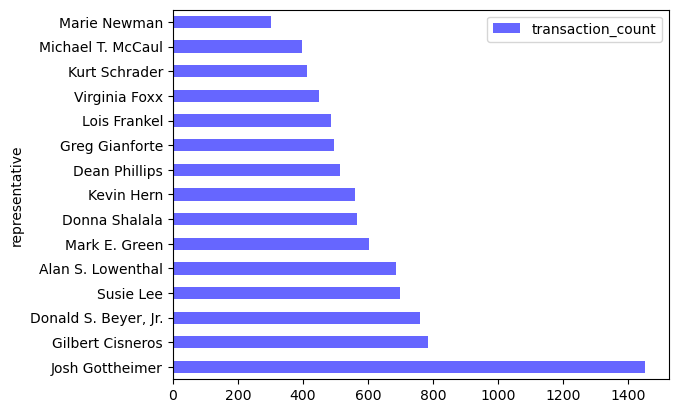

In [103]:
import matplotlib.pyplot as plt

# Resetting the index so 'representative' and 'type' become regular columns
df_reset = rep_transactions.reset_index().head(15)

# Plotting
# Adjust 'x' to the column you want to display on the x-axis (e.g., 'representative', 'type')
# Adjust 'y' to the column you want to display on the y-axis (e.g., 'transaction_count')
plt.figure(figsize=(100, 100))  # Adjust the figure size as needed
df_reset.plot(kind='barh', x='representative', y='transaction_count', color='blue', alpha=0.6)


# Show the plot
plt.show()

In [227]:
df_JG = df[df["representative"] == 'Alan S. Lowenthal']

df_JG.groupby(['ticker', 'type']).agg(
    transaction_counts = ('type', 'count')
).sort_values('transaction_counts', ascending = False)

,,transaction_counts
ticker,type,
RUN,sale_partial,85
--,purchase,28
DKNG,sale_partial,19
DEACU,purchase,18
SH,sale_partial,18
...,...,...
FIDSX,exchange,1
FCYIX,exchange,1
FCNTX,exchange,1


In [236]:
import pandas as pd
import yfinance as yf

# Ensure 'transaction_date' is in datetime format
df['transaction_date'] = pd.to_datetime(df['transaction_date'], errors='coerce')

# Create a new DataFrame to store the fetched data
fetched_data = []

# Unique pairs of ticker and transaction_date
for index, row in df[['ticker', 'transaction_date']].drop_duplicates().iterrows():
    ticker = row['ticker']
    transaction_date = row['transaction_date']

    if pd.notna(transaction_date) and ticker != '--':
        start_date = transaction_date
        end_date = transaction_date + pd.Timedelta(days=7)
        hist = yf.Ticker(ticker).history(start=start_date, end=end_date).head(1)
        if not hist.empty:
            first_row = hist.iloc[0]
            data_dict = {
                'transaction_date': transaction_date,
                'ticker': ticker,
                'processed_date': hist.index[0],  # The date from the index
                'open': first_row['Open'],
                'close': first_row['Close']
            }
            fetched_data.append(data_dict)
            print(data_dict)


fetched_df = pd.DataFrame(fetched_data)

fetched_df.head(25)

df = df.merge(fetched_df, how = 'left', on = ['ticker', 'transaction_date'])

df.to_csv(r'C:\Users\mattl\Downloads\transaction_stock_lkup.csv') 

KAY-S: No timezone found, symbol may be delisted
MSYG: No timezone found, symbol may be delisted
AAIC$B: No timezone found, symbol may be delisted
SCBF: No timezone found, symbol may be delisted
BREIT: No timezone found, symbol may be delisted
FRC: No timezone found, symbol may be delisted
DUK$A: No timezone found, symbol may be delisted
BRK.B: No timezone found, symbol may be delisted
FRC: No timezone found, symbol may be delisted
BRK.B: No timezone found, symbol may be delisted
ATVI: No timezone found, symbol may be delisted
SIVB: No timezone found, symbol may be delisted
SIRE: No timezone found, symbol may be delisted
MPRAU: No timezone found, symbol may be delisted
MMP: No timezone found, symbol may be delisted
FB: No timezone found, symbol may be delisted
FB: No timezone found, symbol may be delisted
CARDANO-USD: No timezone found, symbol may be delisted
BAC.PL: No timezone found, symbol may be delisted
SYNH: No timezone found, symbol may be delisted
KEY$J: No timezone found, symb

KeyboardInterrupt: 